In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14


In [2]:
import numpy as np
import pandas as pd
from collections import namedtuple
import os
import glob
from pathlib import Path

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
from torchvision.transforms import v2


In [4]:
from pymono.cnns import cnn_evaluation, x_single_run, x_train_cnn
from pymono.cnns import Conv2dPars,  MaxPool2dPars,  LinealLayerPars
from pymono.cnns import build_conv_layer, build_conv_layers, build_linear_layers
from pymono.cnns import CNN, ResNet10, ResNet8, ResBlock

In [132]:
from pymono.plt_funcs import  plot_loss, plot_accuracy, cifar_plot_image_and_label 
from pymono.plt_funcs import  plot_energies2, histoplot, plotxyz, plot_dataset
from pymono.cnn_plots import plot_images2, plot_images_and_labels, plot_images_and_positions

In [6]:
from pymono.cnn_aux import get_file_names_format1, get_image_file_data, get_img_file_metadata
from pymono.cnn_aux import get_energy2, get_means_stds2

In [53]:
from pymono.xdataset import XDataset, RDataset
from pymono.mono_dl import mono_data_loader
from pymono.cnn_eval import evaluate_cnnx, cnn_xeval, single_run, train_cnn

In [8]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Local functions

In [9]:
def print_features(train_loader):
    train_features, train_labels = next(iter(train_loader))
    print(f"Feature batch shape: {train_features.size()}")
    print(f"Labels batch shape: {train_labels.size()}")

## Voxelization at 12 mm
- df1c is the directory containing images and labels for events classified as single cluster (1c)
- df2c is the directory containing images and labels for events classified as double cluster (2c)
- dfnc is the directory containing images and labels for events classified as multiple cluster (nc)
- Files are in format1:
    - images files are of the form: images_n.npy, where n is a number.
    - labels are stored in a single file (labels.csv)
 
- Data corresponds to CsITl (50 k MeV rather than 100 k /MeV)

In [81]:
data_dir = Path(os.environ['MONOLITH_DATA'])
dir_root = os.path.join(data_dir,"CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_12mm")
d1c = os.path.join(dir_root,"df1c")
d2c = os.path.join(dir_root,"df2c")
dnc = os.path.join(dir_root,"dfnc")

In [82]:
img_names, csv_name = get_file_names_format1(d1c)

In [83]:
img_names[0]

'/home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_12mm/df1c/images_1.npy'

In [84]:
csv_name

['/home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_12mm/df1c/df1c_12mm.csv']

### Label data
- When sorted by value, label data corresponds to the image stored in the directory.
- event_id = 10000 x image_number, so that event 1004 corresponds to the fourth image in file images_1.npy

In [85]:
df1c = pd.read_csv(csv_name[0])
df1c.head(10)

,event_id,e,x,y,z,t
0,10004,0.510118,18.645067,12.477487,29.249544,0.116340
1,10006,0.509274,13.566376,1.647984,21.156849,0.090734
2,10014,0.509922,-5.014233,5.060986,12.715019,0.062352
3,10018,0.508170,-22.957691,-9.322307,45.483715,0.171746
4,10024,0.508948,-3.514938,-0.639491,15.746504,0.074194
5,10026,0.508879,18.973616,-6.031100,16.421364,0.074508
6,10027,0.508849,11.437413,-22.155209,40.912632,0.157729
7,10028,0.509717,9.708068,3.101630,13.316263,0.064982
8,10029,0.509517,0.335767,-11.193620,21.898740,0.093051
9,10030,0.509092,16.716444,15.401320,25.922293,0.107143


#### Example
- Images and labels in first file of directory

In [90]:
imgs, imgf_path, imgf_name, imfn = get_image_file_data(img_names,img_file_index=0)
print(f"image file path = {imgf_path}")
print(f"image file name = {imgf_name}")
print(f"image file number = {imfn}")
print(f"number of images in file = {len(imgs)}")

df1cs = get_img_file_metadata(df1c, imfn)  # This are the events corresponding to the images
print(f"number of labels in file = {len(df1cs)}")


image file path = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_12mm/df1c/images_1.npy
image file name = images_1.npy
image file number = 1
number of images in file = 3032
number of labels in file = 3032


In [91]:
df1cs.head(10)

,event_id,e,x,y,z,t
0,10004,0.510118,18.645067,12.477487,29.249544,0.116340
1,10006,0.509274,13.566376,1.647984,21.156849,0.090734
2,10014,0.509922,-5.014233,5.060986,12.715019,0.062352
3,10018,0.508170,-22.957691,-9.322307,45.483715,0.171746
4,10024,0.508948,-3.514938,-0.639491,15.746504,0.074194
5,10026,0.508879,18.973616,-6.031100,16.421364,0.074508
6,10027,0.508849,11.437413,-22.155209,40.912632,0.157729
7,10028,0.509717,9.708068,3.101630,13.316263,0.064982
8,10029,0.509517,0.335767,-11.193620,21.898740,0.093051
9,10030,0.509092,16.716444,15.401320,25.922293,0.107143


In [92]:
df1cs.values[0]

array([1.00040000e+04, 5.10118200e-01, 1.86450670e+01, 1.24774870e+01,
       2.92495440e+01, 1.16340004e-01])

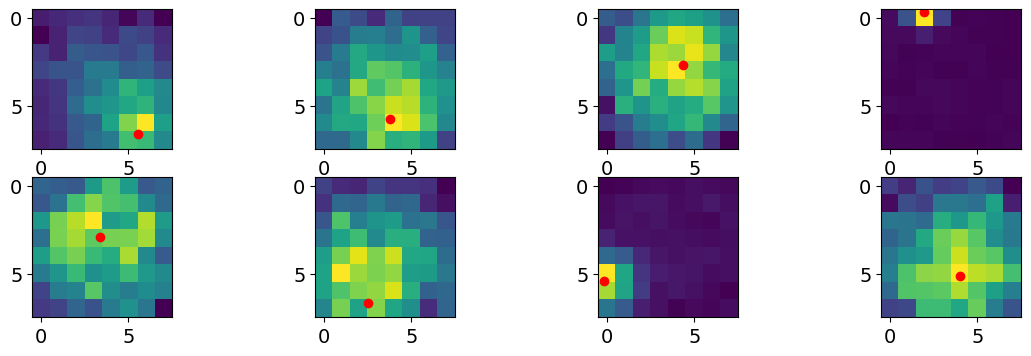

In [93]:
plot_images2(imgs, df1cs, (0,8), pixel_size = 6, grid_size=8)

In [94]:
energy = get_energy2(imgs)

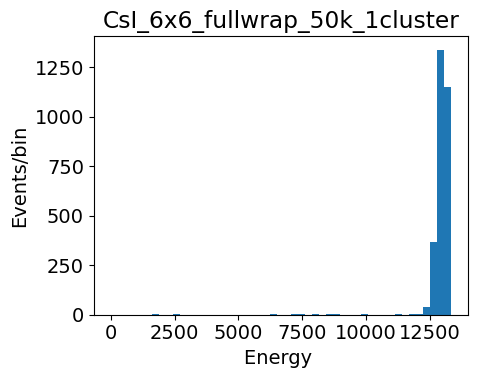

In [95]:
plot_energies2({"CsI_6x6_fullwrap_50k_1cluster":energy}, xmin=0, xmax=max(energy),num_bins = 50)

## Regression

### Load data
- Use RDataset which stores (images, (x,y,z)).
- No normalization.
- No previous classification

In [96]:
first_file = 0  # initial file indx
last_file  = 100  # lasta file indx
batch_size = 100  # Batch size
train_fraction=0.7 
val_fraction=0.2

In [116]:
dataset = RDataset(dir_root, first_file, last_file,type="1c", norm=False)  

Running rDataset with norm = False
Loading files in directory d1c with indexes: 0, 100
   event_id         e          x          y          z         t
0     10004  0.510118  18.645067  12.477487  29.249544  0.116340
1     10006  0.509274  13.566376   1.647984  21.156849  0.090734
2     10014  0.509922  -5.014233   5.060986  12.715019  0.062352
3     10018  0.508170 -22.957691  -9.322307  45.483715  0.171746
4     10024  0.508948  -3.514938  -0.639491  15.746504  0.074194
5     10026  0.508879  18.973616  -6.031100  16.421364  0.074508
6     10027  0.508849  11.437413 -22.155209  40.912632  0.157729
7     10028  0.509717   9.708068   3.101630  13.316263  0.064982
8     10029  0.509517   0.335767 -11.193620  21.898740  0.093051
9     10030  0.509092  16.716444  15.401320  25.922293  0.107143
number of images in file = 3032
number of labels in file = 3032
meta =>[1.00040000e+04 5.10118200e-01 1.86450670e+01 1.24774870e+01
 2.92495440e+01 1.16340004e-01]
meta =>[18.645067 12.477487 29.249

In [130]:
dataset[3]

(tensor([[[ 179.,  718., 2478.,  585.,  124.,  140.,  127.,  117.],
          [ 172.,  173.,  314.,  170.,  149.,  129.,  131.,  121.],
          [ 161.,  127.,  136.,  149.,  149.,  152.,  114.,  120.],
          [ 148.,  141.,  153.,  124.,  129.,  150.,  130.,  128.],
          [ 130.,  132.,  163.,  169.,  143.,  138.,  138.,  143.],
          [ 162.,  154.,  148.,  162.,  152.,  137.,  136.,  144.],
          [ 123.,  140.,  124.,  153.,  138.,  141.,  144.,  133.],
          [ 146.,  147.,  160.,  127.,  129.,  123.,  134.,  142.]]]),
 tensor([-22.9577,  -9.3223,  45.4837]))

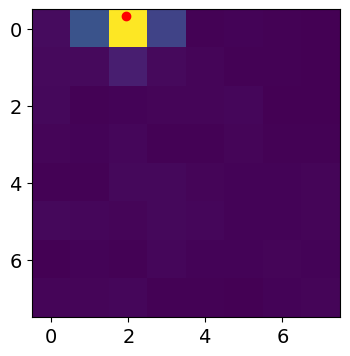

In [133]:
plot_dataset(dataset[3], pixel_size = 6, grid_size=8)

In [134]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 305080 events
 train size = 213556
 val size = 61016
 test size = 30508
 train indices = range(0, 213556)
 val indices = range(213556, 274572)
 test indices = range(274572, 305080)
213556 training events (70.0%)
61016 validation events (20.0%)
30508 test events (10.0%)


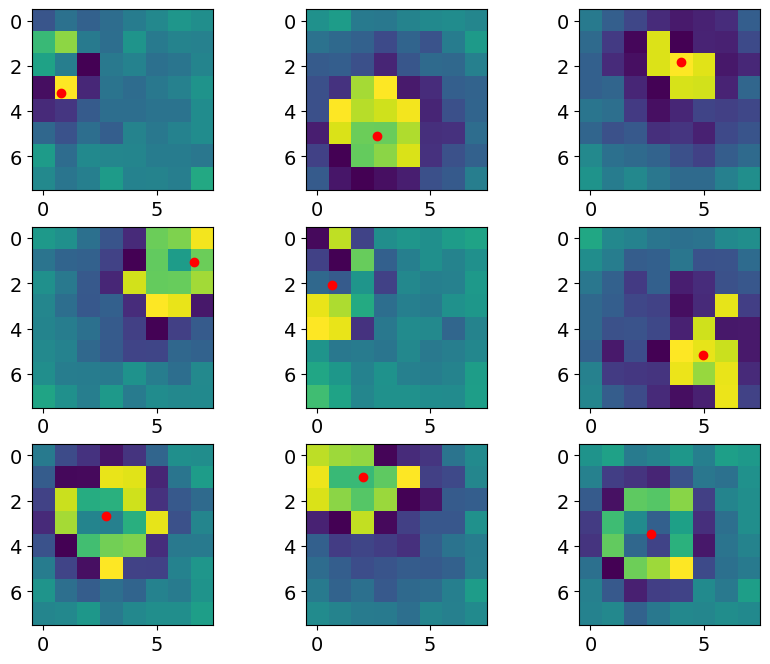

In [135]:
plot_images_and_positions(train_loader, start=0, figsize=(10, 8))

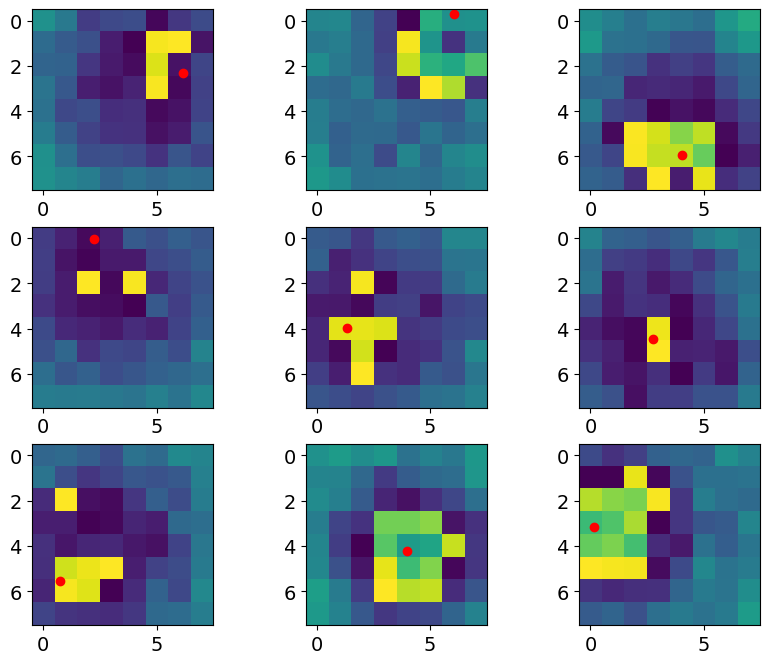

In [136]:
plot_images_and_positions(train_loader, start=10, figsize=(10, 8))

### Define model
- Use simple CNN
- 3 outputs corresponding to regression
- MSE as loss

In [101]:
def build_cnn_l4k3322_conv_layers():
    CL = []
    c1 = Conv2dPars(in_channels=1, out_channels=64, kernel_size=3, padding=1)
    c2 = Conv2dPars(in_channels=64, out_channels=128, kernel_size=3, padding=1)
    c3 = Conv2dPars(in_channels=128, out_channels=256, kernel_size=2, padding=1)
    c4 = Conv2dPars(in_channels=256, out_channels=512, kernel_size=2, padding=1)
    p2d = MaxPool2dPars(kernel_size=2, stride=2)
    CL.append(build_conv_layer(c1, p2d, relu='standard'))
    CL.append(build_conv_layer(c2, p2d, relu='standard'))
    CL.append(build_conv_layer(c3, p2d, relu='standard'))
    CL.append(build_conv_layer(c4, p2d, relu='standard'))
    return CL, build_conv_layers(CL)

In [102]:
def build_cnn_512_3_ll(dropout_fraction=0.25):
    LLYR=[]
    #LLYR.append(LinealLayerPars(512, 256))
    #LLYR.append(LinealLayerPars(256, 128))
    #LLYR.append(LinealLayerPars(128, 2))
    LLYR.append(LinealLayerPars(512, 3))
    return build_linear_layers(LLYR, df=dropout_fraction)

In [103]:
CL, clyrs = build_cnn_l4k3322_conv_layers()

In [104]:
cnn_evaluation(torch.randn(1,1,8,8), CL)

shape of input image = torch.Size([1, 1, 8, 8])
 after cl = 1, shape of out image = torch.Size([1, 64, 4, 4])
 after cl = 2, shape of out image = torch.Size([1, 128, 2, 2])
 after cl = 3, shape of out image = torch.Size([1, 256, 1, 1])
 after cl = 4, shape of out image = torch.Size([1, 512, 1, 1])
shape of flattened image = torch.Size([1, 512])


In [105]:
llyrs = build_cnn_512_3_ll(dropout_fraction=0.25)

In [137]:
model = CNN(clyrs,llyrs).to(device)

In [107]:
print(model)

CNN(
  (conv_layer): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(2, 2

In [108]:
summary(model,(1,8,8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 8, 8]             640
       BatchNorm2d-2             [-1, 64, 8, 8]             128
              ReLU-3             [-1, 64, 8, 8]               0
         MaxPool2d-4             [-1, 64, 4, 4]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
       BatchNorm2d-6            [-1, 128, 4, 4]             256
              ReLU-7            [-1, 128, 4, 4]               0
         MaxPool2d-8            [-1, 128, 2, 2]               0
            Conv2d-9            [-1, 256, 3, 3]         131,328
      BatchNorm2d-10            [-1, 256, 3, 3]             512
             ReLU-11            [-1, 256, 3, 3]               0
        MaxPool2d-12            [-1, 256, 1, 1]               0
           Conv2d-13            [-1, 512, 2, 2]         524,800
      BatchNorm2d-14            [-1, 51

In [138]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [139]:
single_run(train_loader, device, model, optimizer,criterion)

** Run for 1 event**
epoch = 0
i = 0
images = torch.Size([100, 1, 8, 8])
labels = torch.Size([100, 3])
outputs = torch.Size([100, 3])
Train Step 1/2136, Loss: 7.840879917144775
i = 1
images = torch.Size([100, 1, 8, 8])
labels = torch.Size([100, 3])
outputs = torch.Size([100, 3])
Train Step 2/2136, Loss: 7.497835636138916


In [140]:
train_losses, val_losses = train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                     batch_size, epochs=10, iprnt=100)

Training with  ->213600 images
size of train loader  ->2136 images
Evaluating with  ->61100 images
size of eval loader  ->611 images
Running for epochs ->10

EPOCH 0
--- EPOCH 0 AVG TRAIN LOSS: 6.826475987273656
--- EPOCH 0 AVG VAL LOSS: 5.80236017255268

EPOCH 1
--- EPOCH 1 AVG TRAIN LOSS: 6.708855077122035
--- EPOCH 1 AVG VAL LOSS: 6.1761728425658085

EPOCH 2
--- EPOCH 2 AVG TRAIN LOSS: 6.642464809873131
--- EPOCH 2 AVG VAL LOSS: 6.136911943579267

EPOCH 3
--- EPOCH 3 AVG TRAIN LOSS: 6.5751872486836005
--- EPOCH 3 AVG VAL LOSS: 5.91243817997447

EPOCH 4
--- EPOCH 4 AVG TRAIN LOSS: 6.5437537804525
--- EPOCH 4 AVG VAL LOSS: 5.9793597196401045

EPOCH 5
--- EPOCH 5 AVG TRAIN LOSS: 6.486658199561223
--- EPOCH 5 AVG VAL LOSS: 5.65326836729596

EPOCH 6
--- EPOCH 6 AVG TRAIN LOSS: 6.45646566922745
--- EPOCH 6 AVG VAL LOSS: 5.715137120354585

EPOCH 7
--- EPOCH 7 AVG TRAIN LOSS: 6.434979789712456
--- EPOCH 7 AVG VAL LOSS: 5.561782963342245

EPOCH 8
--- EPOCH 8 AVG TRAIN LOSS: 6.36329104614615


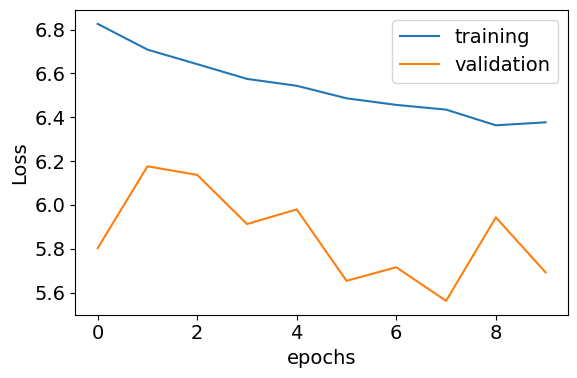

In [141]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

In [142]:
tdeltas = evaluate_cnnx(test_loader, model, device)

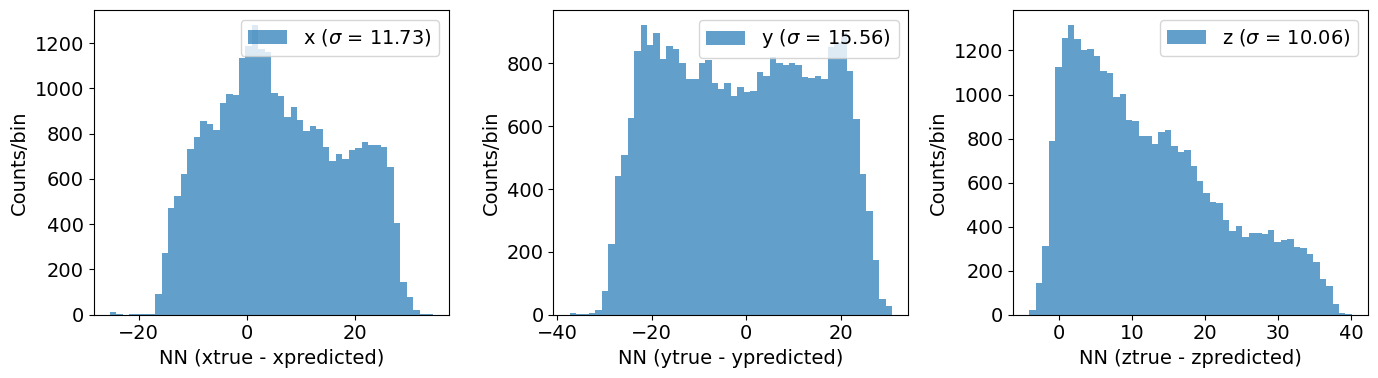

In [143]:
plotxyz(tdeltas, nbins=50)

In [150]:
from pymono.cnn_eval import evaluate_cnn, cnn_evaluation, single_run, train_cnn

In [152]:
from pymono.cnn_func import  CNN

In [148]:
def cnn4L(chi=64, ck=[3,3,3,2], cp=[1,1,1,0], ps=[2,2,2,1], lr=[0.01, 0.01, 0.01, 0.01]):
    """
    Define a cNN with 4 layers. 
    input tensor: (N,C,H,W)

    h = H: Height of image.
    w = W: Width of image.
    ck: Size of the convolution kernel for each layer. 
    cp: Padding of the convolution for each layer.
    ps: stride o the MaxPool.
    lr: negative slope of the leaky relu
    
    """
    cnnt =namedtuple('cnnt', 'conv, relu bn, pool')
    #image = torch.randn(1,1,h,w)
   
    CNNT = []
    CNNT.append(cnnt(nn.Conv2d(1, chi, ck[0], padding=cp[0]), nn.LeakyReLU(negative_slope=cp[0]),nn.BatchNorm2d(chi), nn.MaxPool2d(ps[0], ps[0])))
    CNNT.append(cnnt(nn.Conv2d(chi, chi*2, ck[1], padding=cp[1]), nn.LeakyReLU(negative_slope=cp[1]),nn.BatchNorm2d(chi*2), nn.MaxPool2d(ps[1], ps[1])))
    CNNT.append(cnnt(nn.Conv2d(chi*2, chi*4, ck[2], padding=cp[2]), nn.LeakyReLU(negative_slope=cp[2]), nn.BatchNorm2d(chi*4), nn.MaxPool2d(ps[2], ps[2])))
    CNNT.append(cnnt(nn.Conv2d(chi*4, chi*8, ck[3], padding=cp[3]), nn.LeakyReLU(negative_slope=cp[3]), nn.BatchNorm2d(chi*8), nn.MaxPool2d(ps[3], ps[3])))
    fc0 = nn.Linear(chi*8, 3)
    return CNNT, fc0

In [149]:
CNNT3222, fc0 = cnn4L(chi=64, ck=[3,2,2,2], cp=[1,1,1,1], ps=[2,2,2,2], lr=[0.01, 0.01, 0.01, 0.01])

In [151]:
cnn_evaluation(torch.randn(1,1,8,8), CNNT3222)

shape of input image = torch.Size([1, 1, 8, 8])
shape of image after convolution 0 = torch.Size([1, 64, 8, 8])
shape of image after pool 0= torch.Size([1, 64, 4, 4])
shape of image after convolution 1 = torch.Size([1, 128, 5, 5])
shape of image after pool 1= torch.Size([1, 128, 2, 2])
shape of image after convolution 2 = torch.Size([1, 256, 3, 3])
shape of image after pool 2= torch.Size([1, 256, 1, 1])
shape of image after convolution 3 = torch.Size([1, 512, 2, 2])
shape of image after pool 3= torch.Size([1, 512, 1, 1])
shape of out image = torch.Size([1, 512, 1, 1])
shape of flattened image = torch.Size([1, 512])


In [153]:
model_4L_3222 = CNN(CNNT3222, fc0, dropout=False).to(device)
print(model_4L_3222)

CNN(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=1)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (5): LeakyReLU(negative_slope=1)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (9): LeakyReLU(negative_slope=1)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (13): LeakyReLU(negative_slop

In [154]:
summary(model_4L_3222,(1,8,8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 8, 8]             640
         LeakyReLU-2             [-1, 64, 8, 8]               0
       BatchNorm2d-3             [-1, 64, 8, 8]             128
         MaxPool2d-4             [-1, 64, 4, 4]               0
            Conv2d-5            [-1, 128, 5, 5]          32,896
         LeakyReLU-6            [-1, 128, 5, 5]               0
       BatchNorm2d-7            [-1, 128, 5, 5]             256
         MaxPool2d-8            [-1, 128, 2, 2]               0
            Conv2d-9            [-1, 256, 3, 3]         131,328
        LeakyReLU-10            [-1, 256, 3, 3]               0
      BatchNorm2d-11            [-1, 256, 3, 3]             512
        MaxPool2d-12            [-1, 256, 1, 1]               0
           Conv2d-13            [-1, 512, 2, 2]         524,800
        LeakyReLU-14            [-1, 51

In [156]:
model = CNN(CNNT3222, fc0, dropout=True).to(device)
optimizer = optim.Adam(model_4L_3222.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [157]:
train_losses, val_losses = train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                     batch_size, epochs=10, iprnt=100)

Training with  ->213600 images
size of train loader  ->2136 images
Evaluating with  ->61100 images
size of eval loader  ->611 images
Running for epochs ->10

EPOCH 0
--- EPOCH 0 AVG TRAIN LOSS: 13.166950251056013
--- EPOCH 0 AVG VAL LOSS: 7.941704371556908

EPOCH 1
--- EPOCH 1 AVG TRAIN LOSS: 8.87826211934679
--- EPOCH 1 AVG VAL LOSS: 8.11434022728628

EPOCH 2
--- EPOCH 2 AVG TRAIN LOSS: 8.10626133729456
--- EPOCH 2 AVG VAL LOSS: 7.2500875811725125

EPOCH 3
--- EPOCH 3 AVG TRAIN LOSS: 7.763826062170307
--- EPOCH 3 AVG VAL LOSS: 6.930983702601856

EPOCH 4
--- EPOCH 4 AVG TRAIN LOSS: 7.441787917962235
--- EPOCH 4 AVG VAL LOSS: 6.858442181651213

EPOCH 5
--- EPOCH 5 AVG TRAIN LOSS: 7.242255640721946
--- EPOCH 5 AVG VAL LOSS: 6.3813041099354795

EPOCH 6
--- EPOCH 6 AVG TRAIN LOSS: 7.0792583555318
--- EPOCH 6 AVG VAL LOSS: 6.526546511829582

EPOCH 7
--- EPOCH 7 AVG TRAIN LOSS: 6.945667604605357
--- EPOCH 7 AVG VAL LOSS: 6.113647719647022

EPOCH 8
--- EPOCH 8 AVG TRAIN LOSS: 6.83372776785146

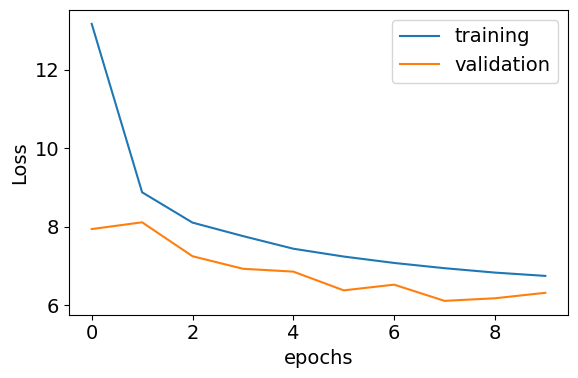

In [158]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

In [159]:
tdeltas = evaluate_cnnx(test_loader, model, device)

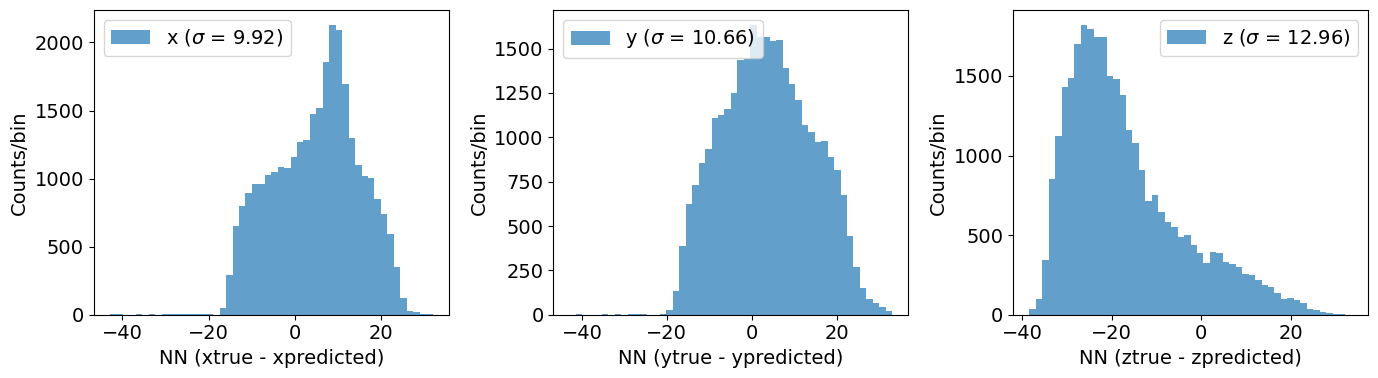

In [160]:
plotxyz(tdeltas, nbins=50)

## Classification

In [23]:
dataset = XDataset(dir_root, first_file, last_file,norm=False)  

Running XDataset with norm = False
directory for 1c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_2_vox_12mm/df1c, 2c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_2_vox_12mm/df2c, >2c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_2_vox_12mm/dfnc
 Image type = 0
 Image type = 1
 Image type = 1
Before shufle: length si: 1026373, si->[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
After shufle: length si: 1026373, si->[683351, 990430, 60366, 144967, 580279, 564105, 326124, 316465, 671872, 789973]


In [24]:
dataset[3]

(tensor([[[ 85.,  81.,  92.,  62.,  54.,  51.,  56.,  49.],
          [ 87., 105.,  97.,  84.,  66.,  47.,  55.,  49.],
          [ 86., 104., 112.,  87.,  80.,  61.,  46.,  49.],
          [107., 111.,  97.,  84.,  74.,  56.,  48.,  51.],
          [ 93., 103.,  93.,  95.,  77.,  74.,  54.,  46.],
          [ 78.,  89.,  89.,  76.,  68.,  55.,  36.,  50.],
          [ 62.,  77.,  62.,  66.,  64.,  47.,  43.,  35.],
          [ 63.,  53.,  51.,  64.,  42.,  54.,  57.,  38.]]]),
 tensor(0))

In [25]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 1026373 events
 train size = 718461
 val size = 205274
 test size = 102638
 train indices = range(0, 718461)
 val indices = range(718461, 923735)
 test indices = range(923735, 1026373)
718461 training events (69.99999025695337%)
205274 validation events (19.99994154172021%)
102638 test events (10.000068201326417%)


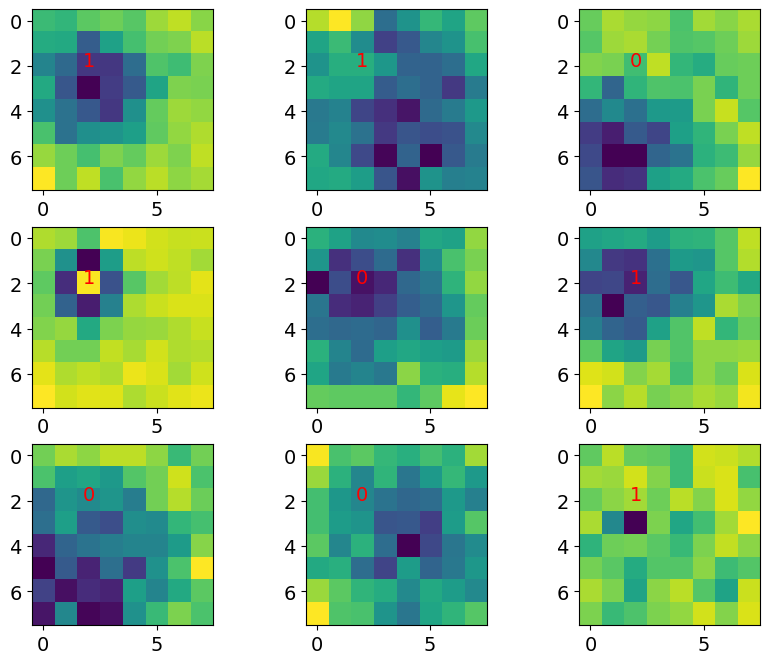

In [26]:
plot_images_and_labels(train_loader, start=100, figsize=(10, 8))

In [27]:
CL = []
c1 = Conv2dPars(in_channels=1, out_channels=64, kernel_size=3, padding=1)
c2 = Conv2dPars(in_channels=64, out_channels=128, kernel_size=3, padding=1)
c3 = Conv2dPars(in_channels=128, out_channels=256, kernel_size=2, padding=1)
c4 = Conv2dPars(in_channels=256, out_channels=512, kernel_size=2, padding=1)
p2d = MaxPool2dPars(kernel_size=2, stride=2)
CL.append(build_conv_layer(c1, p2d, relu='standard'))
CL.append(build_conv_layer(c2, p2d, relu='standard'))
CL.append(build_conv_layer(c3, p2d, relu='standard'))
CL.append(build_conv_layer(c4, p2d, relu='standard'))
clyrs = build_conv_layers(CL)

In [28]:
cnn_evaluation(torch.randn(1,1,8,8), CL)

shape of input image = torch.Size([1, 1, 8, 8])
 after cl = 1, shape of out image = torch.Size([1, 64, 4, 4])
 after cl = 2, shape of out image = torch.Size([1, 128, 2, 2])
 after cl = 3, shape of out image = torch.Size([1, 256, 1, 1])
 after cl = 4, shape of out image = torch.Size([1, 512, 1, 1])
shape of flattened image = torch.Size([1, 512])


In [37]:
LLYR=[]
#LLYR.append(LinealLayerPars(512, 256))
#LLYR.append(LinealLayerPars(256, 128))
#LLYR.append(LinealLayerPars(128, 2))
LLYR.append(LinealLayerPars(512, 2))
llyrs = build_linear_layers(LLYR, df=0.25)

In [38]:
model = CNN(clyrs,llyrs).to(device)

In [39]:
summary(model,(1,8,8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 8, 8]             640
       BatchNorm2d-2             [-1, 64, 8, 8]             128
              ReLU-3             [-1, 64, 8, 8]               0
         MaxPool2d-4             [-1, 64, 4, 4]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
       BatchNorm2d-6            [-1, 128, 4, 4]             256
              ReLU-7            [-1, 128, 4, 4]               0
         MaxPool2d-8            [-1, 128, 2, 2]               0
            Conv2d-9            [-1, 256, 3, 3]         131,328
      BatchNorm2d-10            [-1, 256, 3, 3]             512
             ReLU-11            [-1, 256, 3, 3]               0
        MaxPool2d-12            [-1, 256, 1, 1]               0
           Conv2d-13            [-1, 512, 2, 2]         524,800
      BatchNorm2d-14            [-1, 51

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay = 0.001, momentum = 0.9)  


In [41]:
x_single_run(train_loader, device, model, optimizer, criterion, xc=True)

** Run for 1 event**
epoch = 0
i = 0
labels shape = torch.Size([100])
imgs shape = torch.Size([100, 1, 8, 8])
labels = tensor([0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
        1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        1, 1, 0, 0])
outputs = torch.Size([100, 2])
predicted label = tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0], device='cuda:0')
correct = 42
Train Step 1/7185, Loss: 0.7013516426086426
i = 1
labels shape = torch.Size([100])
imgs shape = torch.Size([100, 1, 8, 8

In [42]:
train_losses, val_losses, acc = x_train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                            batch_size=64, xc=True,
                                            iprnt=100, epochs=10)

Training with  ->459840 images
size of train loader  ->7185 images
Evaluating with  ->131392 images
size of eval loader  ->2053 images
Classification  ->True
Running for epochs ->10

EPOCH 0
training step: size of sample 7185
Train Step 6400/7185, Loss: 0.6167123317718506
Validation step: size of sample 2053
--- EPOCH 0 AVG TRAIN LOSS: 0.5852345669651164
--- EPOCH 0 AVG VAL LOSS: 0.6000845691255401
Accuracy on the 2053 validation images: 67.4303613706558 %

EPOCH 1
training step: size of sample 7185
Train Step 6400/7185, Loss: 0.5542140007019043
Validation step: size of sample 2053
--- EPOCH 1 AVG TRAIN LOSS: 0.5835599935668662
--- EPOCH 1 AVG VAL LOSS: 0.5993762073491297
Accuracy on the 2053 validation images: 67.63009441039782 %

EPOCH 2
training step: size of sample 7185
Train Step 6400/7185, Loss: 0.5835341215133667
Validation step: size of sample 2053
--- EPOCH 2 AVG TRAIN LOSS: 0.5830082030286371
--- EPOCH 2 AVG VAL LOSS: 0.605509142932576
Accuracy on the 2053 validation images: 

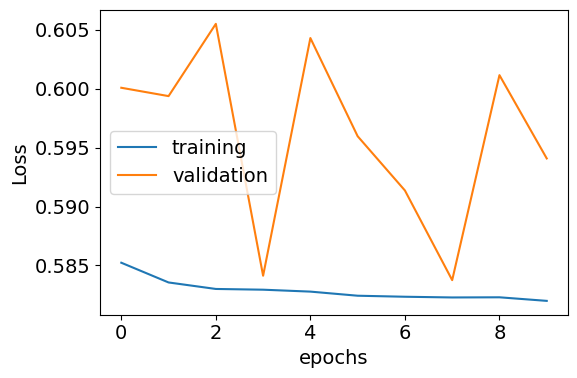

In [43]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

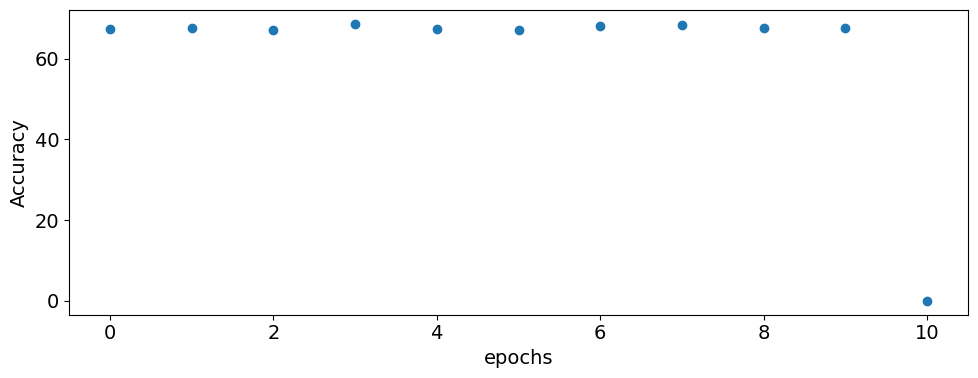

In [46]:
plot_accuracy(acc, figsize=(10, 4))

## Normalization

In [47]:
means, stds = get_means_stds2(dir=d1c)

files in dir: 200
shape -> (3102, 8, 8)
mean img0 =74.140625
std  img0 =87.57744598388672


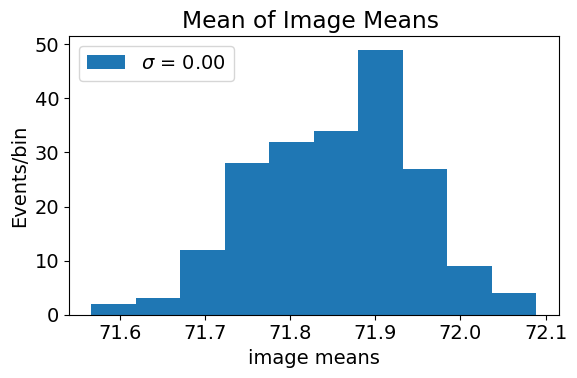

In [48]:
meansx =[np.mean(x) for x in means]
histoplot(meansx, "image means", vart="Mean of Image Means ", num_bins = 10, figsize=(6, 4))

In [49]:
imean = np.mean(meansx)

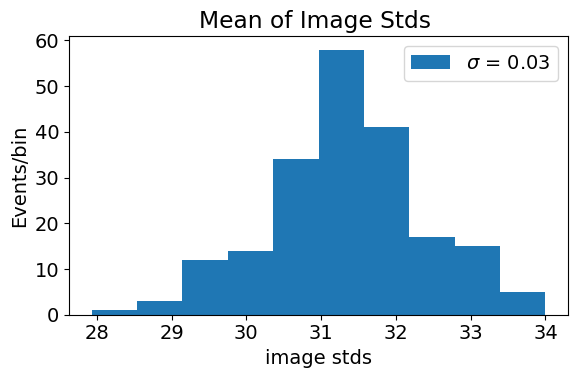

In [50]:
stdsx =[np.std(x) for x in stds]
histoplot(stdsx, "image stds", vart="Mean of Image Stds ", num_bins = 10, figsize=(6, 4))

In [51]:
isigma = np.mean(stdsx)

In [52]:
print(f"Normalization: mean = {imean}, std = {isigma}")

Normalization: mean = 71.85580444335938, std = 31.351606369018555


In [53]:
means2, stds2 = get_means_stds2(dir=d2c)

files in dir: 200
shape -> (1672, 8, 8)
mean img0 =72.859375
std  img0 =85.17002868652344


In [54]:
folder_h5    = "CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5"

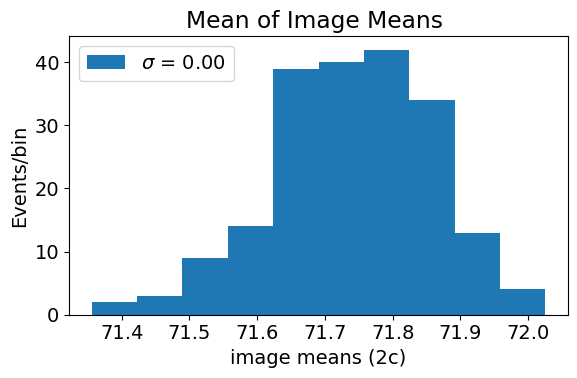

In [55]:
meansx2 =[np.mean(x) for x in means2]
histoplot(meansx2, "image means (2c)", vart="Mean of Image Means ", num_bins = 10, figsize=(6, 4))

In [56]:
imean2 = np.mean(meansx2)

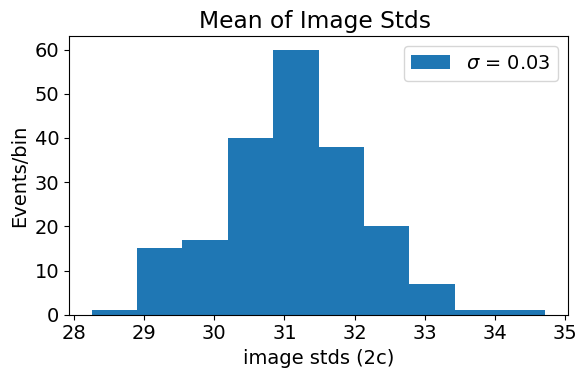

In [57]:
stdsx2 =[np.std(x) for x in stds2]
histoplot(stdsx2, "image stds (2c)", vart="Mean of Image Stds ", num_bins = 10, figsize=(6, 4))

In [58]:
isigma2 = np.mean(stdsx2)

In [59]:
print(f"Normalization 2c: mean = {imean2}, std = {isigma2}")

Normalization 2c: mean = 71.74212646484375, std = 31.144062042236328


In [60]:
means3, stds3 = get_means_stds2(dir=dnc)

files in dir: 200
shape -> (398, 8, 8)
mean img0 =72.234375
std  img0 =18.482036590576172


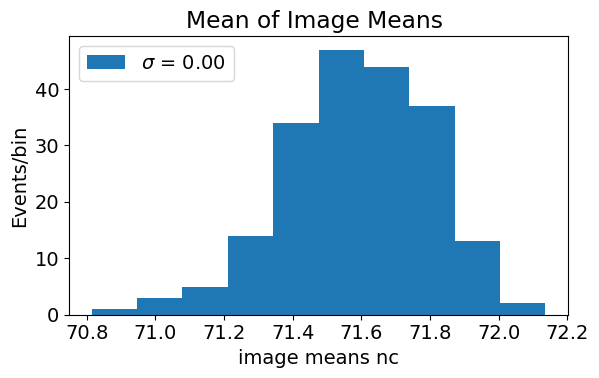

In [61]:
meansx3 =[np.mean(x) for x in means3]
histoplot(meansx3, "image means nc", vart="Mean of Image Means ", num_bins = 10, figsize=(6, 4))

In [62]:
imean3 = np.mean(meansx3)

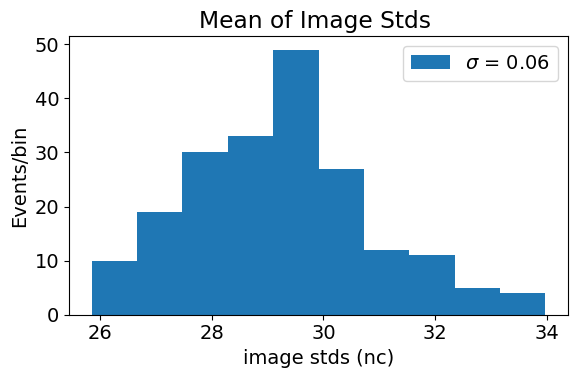

In [63]:
stdsx3 =[np.std(x) for x in stds3]
histoplot(stdsx3, "image stds (nc)", vart="Mean of Image Stds ", num_bins = 10, figsize=(6, 4))

In [64]:
isigma3 = np.mean(stdsx3)

In [65]:
print(f"Normalization nc: mean = {imean3}, std = {isigma3}")

Normalization nc: mean = 71.5923080444336, std = 29.235815048217773


### Run with full stats and normalization

In [66]:
dataset = XDataset(dir_root, first_file, last_file,norm=True, mean=imean, std=isigma)  # No comparison with energy only xyz


Running XDataset with norm = True
directory for 1c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_2_vox_12mm/df1c, 2c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_2_vox_12mm/df2c, >2c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_2_vox_12mm/dfnc
 Image type = 0
 Image type = 1
 Image type = 1
Before shufle: length si: 1026373, si->[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
After shufle: length si: 1026373, si->[683351, 990430, 60366, 144967, 580279, 564105, 326124, 316465, 671872, 789973]


In [67]:
dataset[3]

(tensor([[[ 0.4193,  0.2917,  0.6425, -0.3144, -0.5695, -0.6652, -0.5057,
           -0.7290],
          [ 0.4830,  1.0572,  0.8020,  0.3874, -0.1868, -0.7928, -0.5376,
           -0.7290],
          [ 0.4511,  1.0253,  1.2805,  0.4830,  0.2598, -0.3463, -0.8247,
           -0.7290],
          [ 1.1210,  1.2486,  0.8020,  0.3874,  0.0684, -0.5057, -0.7609,
           -0.6652],
          [ 0.6744,  0.9934,  0.6744,  0.7382,  0.1641,  0.0684, -0.5695,
           -0.8247],
          [ 0.1960,  0.5468,  0.5468,  0.1322, -0.1230, -0.5376, -1.1437,
           -0.6971],
          [-0.3144,  0.1641, -0.3144, -0.1868, -0.2506, -0.7928, -0.9204,
           -1.1756],
          [-0.2825, -0.6014, -0.6652, -0.2506, -0.9523, -0.5695, -0.4738,
           -1.0799]]]),
 tensor(0))

In [104]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 1026373 events
 train size = 718461
 val size = 205274
 test size = 102638
 train indices = range(0, 718461)
 val indices = range(718461, 923735)
 test indices = range(923735, 1026373)
718461 training events (69.99999025695337%)
205274 validation events (19.99994154172021%)
102638 test events (10.000068201326417%)


In [69]:
model = CNN(clyrs,llyrs).to(device)

In [70]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay = 0.001, momentum = 0.9)  


In [71]:
train_losses, val_losses, acc = x_train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                            batch_size=64, xc=True,
                                            iprnt=100, epochs=10)

Training with  ->459840 images
size of train loader  ->7185 images
Evaluating with  ->131392 images
size of eval loader  ->2053 images
Classification  ->True
Running for epochs ->10

EPOCH 0
training step: size of sample 7185
Train Step 6400/7185, Loss: 0.6349964737892151
Validation step: size of sample 2053
--- EPOCH 0 AVG TRAIN LOSS: 0.5839982049657639
--- EPOCH 0 AVG VAL LOSS: 0.5888042242510749
Accuracy on the 2053 validation images: 67.77867630581564 %

EPOCH 1
training step: size of sample 7185
Train Step 6400/7185, Loss: 0.5249385237693787
Validation step: size of sample 2053
--- EPOCH 1 AVG TRAIN LOSS: 0.5817372677926812
--- EPOCH 1 AVG VAL LOSS: 0.602467807687554
Accuracy on the 2053 validation images: 65.81349805625652 %

EPOCH 2
training step: size of sample 7185
Train Step 6400/7185, Loss: 0.5573007464408875
Validation step: size of sample 2053
--- EPOCH 2 AVG TRAIN LOSS: 0.581318506866009
--- EPOCH 2 AVG VAL LOSS: 0.5970543224348188
Accuracy on the 2053 validation images: 

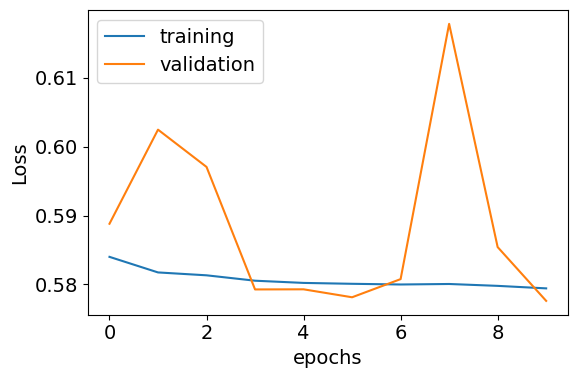

In [72]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

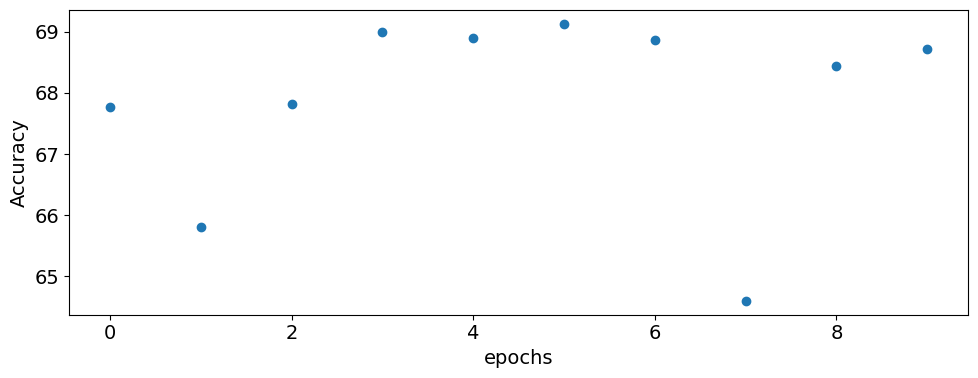

In [73]:
plot_accuracy(acc,figsize=(10, 4))

## Resnet

In [80]:
model = ResNet8(ResBlock, in_channels=1, out_channels=64, num_classes = 2, 
                 dropout_fraction=0.25, debug=True, dropout=True).to(device)

 ## make_layer 1: planes = 64,  blocks = 1, stride = 1
 ## make_layer: in_planes=64
 ## make_layer: downsample = None
 ## make_layer 2: planes = 128,  blocks = 1, stride = 2
 ## make_layer: in_planes=64
 ## make_layer: downsample = Sequential(
  (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 3: planes = 256,  blocks = 1, stride = 2
 ## make_layer: in_planes=128
 ## make_layer: downsample = Sequential(
  (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 4: planes = 512,  blocks = 1, stride = 2
 ## make_layer: in_planes=256
 ## make_layer: downsample = Sequential(
  (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [81]:
model(torch.randn(10,1,8,8).to(device))

  ResNet8: input data shape =>torch.Size([10, 1, 8, 8])
  ResNet8: after conv1 =>torch.Size([10, 64, 8, 8])
  ResNet8: after layer0 =>torch.Size([10, 64, 8, 8])
  ResNet8: after layer1 =>torch.Size([10, 128, 4, 4])
  ResNet8: after layer2 =>torch.Size([10, 256, 2, 2])
  ResNet8: after layer3 =>torch.Size([10, 512, 1, 1])
  ResNet8: after avgpool =>torch.Size([10, 512, 1, 1])
  ResNet8: after flatten =>torch.Size([10, 512])
  ResNet8: after fc =>torch.Size([10, 2])


tensor([[-4.7656e-01,  8.9132e-01],
        [-9.1326e-01,  4.3694e-01],
        [-7.7299e-01, -8.1911e-01],
        [-3.3129e-01, -1.3971e-01],
        [ 2.8471e-05, -4.6969e-01],
        [ 5.2154e-01, -8.5137e-01],
        [ 7.3590e-01, -3.9934e-01],
        [-7.5673e-02, -7.3944e-01],
        [ 4.3718e-02, -2.0146e-01],
        [ 3.5995e-01,  5.2574e-01]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [82]:
summary(model,(1,8,8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 8, 8]             640
       BatchNorm2d-2             [-1, 64, 8, 8]             128
              ReLU-3             [-1, 64, 8, 8]               0
            Conv2d-4             [-1, 64, 8, 8]          36,928
       BatchNorm2d-5             [-1, 64, 8, 8]             128
              ReLU-6             [-1, 64, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          36,928
       BatchNorm2d-8             [-1, 64, 8, 8]             128
              ReLU-9             [-1, 64, 8, 8]               0
         ResBlock-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 128, 4, 4]          73,856
      BatchNorm2d-12            [-1, 128, 4, 4]             256
             ReLU-13            [-1, 128, 4, 4]               0
           Conv2d-14            [-1, 12

In [83]:
optimizer= optim.Adam(model.parameters(), lr=0.001)

In [84]:
train_losses, val_losses, acc = x_train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                            batch_size=64, xc=True,
                                            iprnt=100, epochs=20)

Training with  ->459840 images
size of train loader  ->7185 images
Evaluating with  ->131392 images
size of eval loader  ->2053 images
Classification  ->True
Running for epochs ->20

EPOCH 0
training step: size of sample 7185
Train Step 6400/7185, Loss: 0.6115539073944092
Validation step: size of sample 2053
--- EPOCH 0 AVG TRAIN LOSS: 0.603529220852656
--- EPOCH 0 AVG VAL LOSS: 0.5810286622772086
Accuracy on the 2053 validation images: 68.84505587653575 %

EPOCH 1
training step: size of sample 7185
Train Step 6400/7185, Loss: 0.5825582146644592
Validation step: size of sample 2053
--- EPOCH 1 AVG TRAIN LOSS: 0.5739311232281461
--- EPOCH 1 AVG VAL LOSS: 0.5643009970783897
Accuracy on the 2053 validation images: 69.90899967847852 %

EPOCH 2
training step: size of sample 7185
Train Step 6400/7185, Loss: 0.6284098029136658
Validation step: size of sample 2053
--- EPOCH 2 AVG TRAIN LOSS: 0.5631433654511729
--- EPOCH 2 AVG VAL LOSS: 0.5616535250001341
Accuracy on the 2053 validation images:

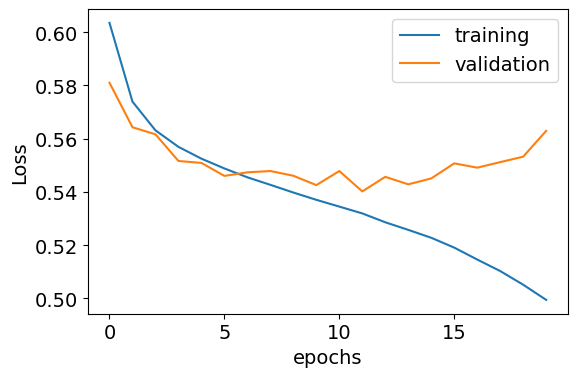

In [85]:
plot_loss(20, train_losses, val_losses,figsize=(6, 4))

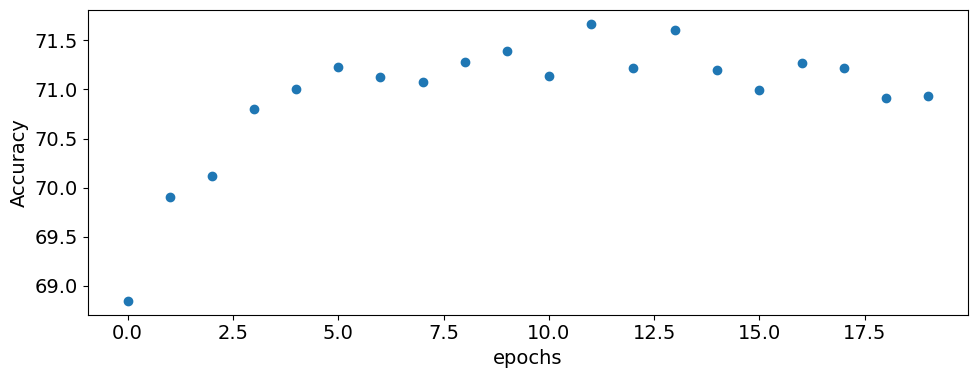

In [86]:
plot_accuracy(acc,figsize=(10, 4))

## Study accuracy

In [87]:
dataset1c = XDataset(dir_root, first_file, last_file, type="1c", norm=False)  

Running XDataset with norm = False
directory for 1c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_2_vox_12mm/df1c, 2c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_2_vox_12mm/df2c, >2c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_2_vox_12mm/dfnc
 Image type = 0
Before shufle: length si: 614775, si->[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
After shufle: length si: 614775, si->[593460, 25893, 465875, 325977, 326954, 466074, 307987, 186557, 273324, 312344]


In [94]:
data_loader = DataLoader(dataset1c, batch_size=10, shuffle=False) # data already shuffled

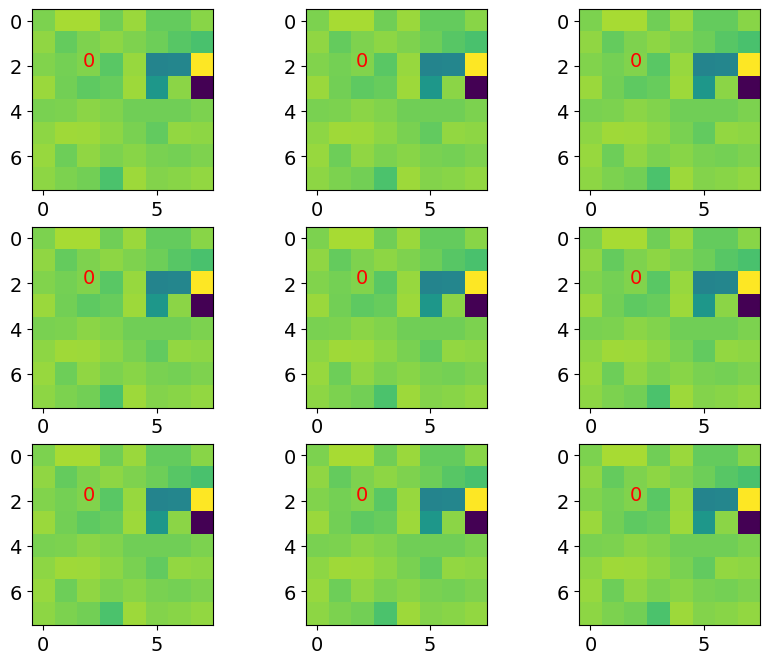

In [95]:
plot_images_and_labels(data_loader, start=0, figsize=(10, 8))

In [122]:
total, t1c, t2c, acc, c1c, c2c = cnn_xeval(test_loader, model, device, prnt=1000) 
print(f"Events analyzed = {total}: 1c = {t1c}, 2c = {t2c}")
print(f"Events correctly identified = {acc}")
print(f"1c correctly identified as 1c = {c1c}")
print(f"2c correctly identified as 2c = {c2c}")

Validation step: size of sample 1027
i = 0
labels = tensor([0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
        1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
        1, 0, 1, 1], device='cuda:0')
predicted = tensor([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0], device='cuda:0')
correct = 66
labels 0 = tensor([ 0,  1,  4,  5,  8, 11, 14, 15, 17, 18, 19, 20, 22, 23, 25, 26, 27, 29,
        30, 32, 33, 34, 35, 38, 39, 40, 43, 44, 45, 46, 47, 49, 50, 51, 55, 59,
        61, 62, 63, 67, 68, 69, 70, 

## Use Resnet to predict position on 1c and on the full set.

In [148]:
dataset1c = RDataset(dir_root, first_file, last_file, type="1c", norm=False)  

Running rDataset with norm = False
Loading files in directory d1c with indexes: 0, 200
number of images in file = 3049
number of labels in file = 3049
meta =>[ 1.0006000e+04  5.0992167e-01 -1.1797090e+01 -1.8706337e+01
  1.9845798e+01  1.2897693e-01]
meta =>[-11.79709  -18.706337  19.845798]
Before shufle: length si: 614775, si->[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
After shufle: length si: 614775, si->[593460, 25893, 465875, 325977, 326954, 466074, 307987, 186557, 273324, 312344]


In [149]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset1c, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 614775 events
 train size = 430342
 val size = 122955
 test size = 61478
 train indices = range(0, 430342)
 val indices = range(430342, 553297)
 test indices = range(553297, 614775)
430342 training events (69.9999186694319%)
122955 validation events (20.0%)
61478 test events (10.000081330568094%)


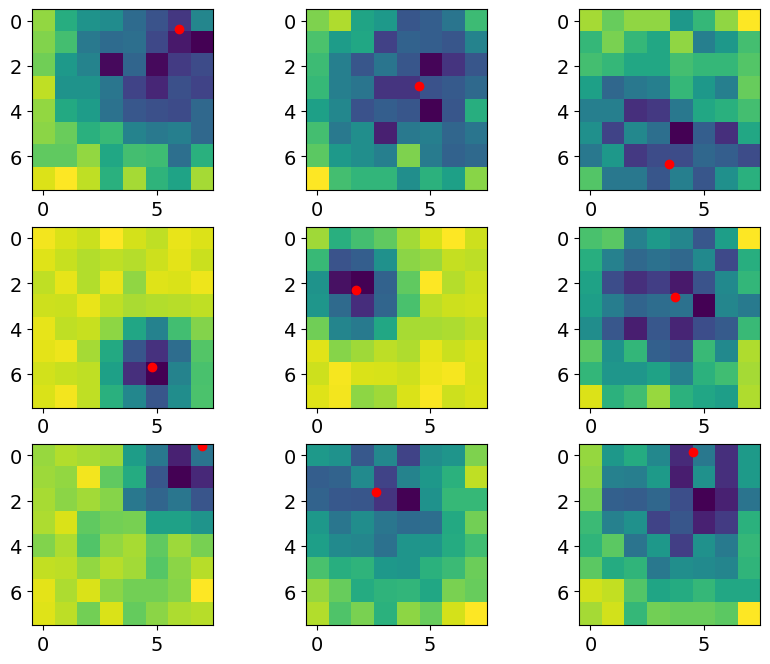

In [150]:
plot_images_and_positions(train_loader, start=0, figsize=(10, 8))

In [151]:
model = ResNet8(ResBlock, in_channels=1, out_channels=64, num_classes = 3, 
                 dropout_fraction=0.25, debug=True, dropout=True).to(device)

 ## make_layer 1: planes = 64,  blocks = 1, stride = 1
 ## make_layer: in_planes=64
 ## make_layer: downsample = None
 ## make_layer 2: planes = 128,  blocks = 1, stride = 2
 ## make_layer: in_planes=64
 ## make_layer: downsample = Sequential(
  (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 3: planes = 256,  blocks = 1, stride = 2
 ## make_layer: in_planes=128
 ## make_layer: downsample = Sequential(
  (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 4: planes = 512,  blocks = 1, stride = 2
 ## make_layer: in_planes=256
 ## make_layer: downsample = Sequential(
  (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
ptimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [153]:
train_losses, val_losses = x_train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                            batch_size=100, xc=False,
                                            iprnt=100, epochs=10)

Training with  ->430400 images
size of train loader  ->4304 images
Evaluating with  ->123000 images
size of eval loader  ->1230 images
Classification  ->False
Running for epochs ->10

EPOCH 0
training step: size of sample 4304
Validation step: size of sample 1230
--- EPOCH 0 AVG TRAIN LOSS: 10.908280982445497
--- EPOCH 0 AVG VAL LOSS: 10.535408452371271

EPOCH 1
training step: size of sample 4304
Validation step: size of sample 1230
--- EPOCH 1 AVG TRAIN LOSS: 10.93105578685671
--- EPOCH 1 AVG VAL LOSS: 10.113266639281216

EPOCH 2
training step: size of sample 4304
Validation step: size of sample 1230
--- EPOCH 2 AVG TRAIN LOSS: 10.943950280412118
--- EPOCH 2 AVG VAL LOSS: 10.771707593207436

EPOCH 3
training step: size of sample 4304
Validation step: size of sample 1230
--- EPOCH 3 AVG TRAIN LOSS: 10.925015200777706
--- EPOCH 3 AVG VAL LOSS: 10.700809295142326

EPOCH 4
training step: size of sample 4304
Validation step: size of sample 1230
--- EPOCH 4 AVG TRAIN LOSS: 10.93219711817108

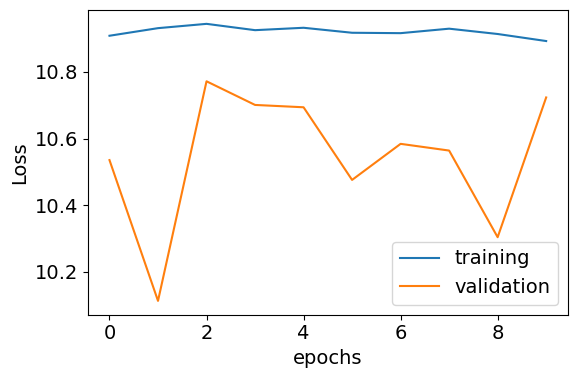

In [154]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

In [157]:
tdeltas = evaluate_cnnx(test_loader, model, device)

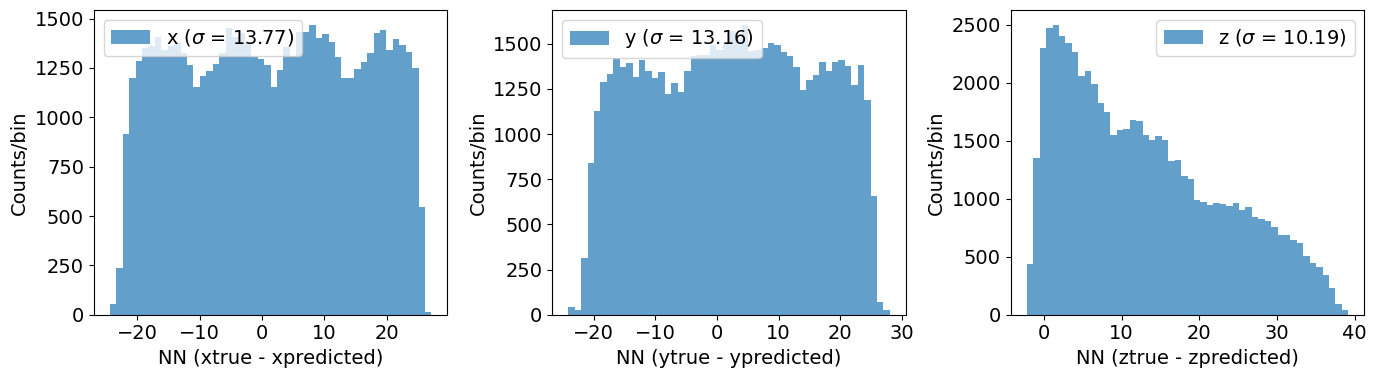

In [160]:
plotxyz(tdeltas, nbins=50)